In [28]:
import os.path as p
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data.dataloader import DataLoader
from definitions import *
from model_helper_functions import *
from dataset_helper_functions import *
from bi_lstm import BiLSTM
from bert_embedding_model import BertEmbeddingModel
from DebatesDataset import DebatesDataset


In [2]:
try:
    IS_MASTER
except: 
    IS_MASTER = False

In [3]:
if not IS_MASTER:
    data, features = {}, {}
    emb_model = 'all-mpnet-base-v2'#'multi-qa-mpnet-base-dot-v1'#'all-MiniLM-L6-v2'
    
    dev_path = p.join(PROC_DATA_DIR_PATH, 'dev')
    features_path = p.join(PROC_DATA_DIR_PATH, 'features')

    data_paths = {
        'dev': [
            p.join(dev_path, 'dev.tsv'),
            p.join(dev_path, 'dev_spacy.pkl'),
            p.join(features_path, 'dev_stylometric_features.pkl'),
        ],
        'test': [
            p.join(POLIT_DATA_DIR_PATH, 'test', 'test_combined.tsv'),
            p.join(PROC_DATA_DIR_PATH, 'test', 'test_spacy.pkl'),
            p.join(features_path, 'test_stylometric_features.pkl'),

        ],
        'train': [
            p.join(POLIT_DATA_DIR_PATH, 'train', 'train_combined.tsv'),
            p.join(PROC_DATA_DIR_PATH, 'train', 'train_spacy.pkl'),
            p.join(features_path, 'train_stylometric_features.pkl')
        ],
        'val': [
            p.join(POLIT_DATA_DIR_PATH, 'val', 'val_combined.tsv'),
            p.join(PROC_DATA_DIR_PATH, 'val', 'val_spacy.pkl'),
            p.join(features_path, 'val_stylometric_features.pkl'),
        ],
    }

    for dtype, dpaths in data_paths.items():
        try:
            data[dtype] = pd.read_pickle(dpaths[1])
            features[dtype] = pd.read_pickle(dpaths[2])
        except Exception as e:
            print(e.args)
            exit()

Remove validation records from train dataset.

In [4]:
dev_df, test_df, train_df, val_df = data.values()

In [5]:
# val_ids = data['val']['id'].values
# train_df = data['train']
# train_df = train_df.loc[~train_df['id'].isin(val_ids)].reset_index(drop=True)
dev_ids = dev_df['id'].values
val_df = val_df.loc[~val_df['id'].isin(dev_ids)]


In [ ]:
# gpu
train_worthy = train_df.loc[train_df['label'] == 1]
val_worthy = train_worthy.iloc[250:, :]
train_worthy = train_worthy.iloc[:250, :]
train_unworthy = train_df.loc[train_df['label'] == 0].iloc[:len(train_worthy)*2, :]
ratio = len(train_unworthy) / len(train_worthy)

imbalanced_train = train_worthy.append(train_unworthy).reset_index(drop=True)

In [6]:
# val_worthy = val_df.loc[val_df['label'] == 1]
val_unworthy = val_df.loc[val_df['label'] == 0].iloc[:len(val_worthy), :]

balanced_val = val_worthy.append(val_unworthy).reset_index(drop=True)

test_worthy = test_df.loc[test_df['label'] == 1]
test_unworthy = test_df.loc[test_df['label'] == 0].iloc[:len(test_worthy), :]

balanced_test = test_worthy.append(test_unworthy).reset_index(drop=True)

Wrap data in `DebatesDataset` class so that it can be passed to `DataLoader` class.

In [7]:
batch_size = 16
transform = None

dd_train = DebatesDataset(data=imbalanced_train, transform=transform)
dd_val = DebatesDataset(data=balanced_val, transform=transform)
dd_test = DebatesDataset(data=balanced_test, transform=transform)

sent_level_feature_dim = len(dd_train[0][3]) if not transform else len(dd_train[0][4])

loader_train = DataLoader(dd_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dd_val, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dd_test, batch_size=batch_size, shuffle=True)

Initialize model, optimizer and criterion.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_model = BertEmbeddingModel(device=device)
model = BiLSTM(
    embedding_dim=embedding_model.dim,
    sent_level_feature_dim=sent_level_feature_dim
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0])).to(device)
n_epochs = 5
eval_period = len(loader_train) // 2
best_val_loss = float("Inf")
exp_path = p.join(EXP_DIR_PATH, 'bi-lstm', 'test-bcewlogitsloss')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialize running values.

In [9]:
running_loss, val_running_loss = 0.0, 0.0
global_step = 0
train_losses, val_losses, global_steps = [], [], []

Training process.

In [10]:
model.train()

for epoch in range(n_epochs):
    for ids, sentences, labels, features in loader_train:
        labels = labels.float().to(device)

        output = model(sentences)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update running values
        running_loss += loss.item()
        global_step += 1

        if global_step % eval_period == 0:
            model.eval()
            with torch.no_grad():
                for val_ids, val_sentences, val_labels, val_features in loader_val:
                    val_labels = val_labels.float().to(device)
                    output = model(val_sentences)

                    loss = criterion(output, val_labels)
                    val_running_loss += loss.item()

            train_losses.append(running_loss / eval_period)
            val_losses.append(val_running_loss / len(loader_val))
            global_steps.append(global_step)

            running_loss, val_running_loss = 0.0, 0.0

            print(
                f'Epoch [{epoch+1}/{n_epochs}], '
                f'Step [{global_step}/{n_epochs*len(loader_train)}], '
                f'Train Loss: {train_losses[-1]:.4f}, '
                f'Validation Loss: {val_losses[-1]:.4f}'
            )

            # TODO: early stopping here ?
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]

                save_checkpoint(
                    p.join(exp_path, 'model.pt'),
                    model=model,
                    optimizer=optimizer,
                    val_loss=best_val_loss
                )
                save_metrics(
                    p.join(exp_path, 'metrics.pt'),
                    train_loss_list=train_losses,
                    val_loss_list=val_losses,
                    global_steps_list=global_steps
                    
                )
                
save_metrics(
    p.join(exp_path, 'metrics.pt'),
    train_loss_list=train_losses,
    val_loss_list=val_losses,
    global_steps_list=global_steps
)

# save_params(
#     p.join(exp_path, 'params.pt'),
#     params={}
# )
"Done."

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Epoch [1/5], Step [20/205], Train Loss: 0.6844, Validation Loss: 0.6253
Model saved to ==> /Users/icobx/Documents/skola/dp/code/dt/exp/bi-lstm/vanilla/model.pt
Model saved to ==> /Users/icobx/Documents/skola/dp/code/dt/exp/bi-lstm/vanilla/metrics.pt
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Epoch [1/5], Step [40/205], Train Loss: 0.6118, Validation Loss: 0.5676
Model saved to ==> /Users/icobx/Documents/skola/dp/code/dt/exp/bi-lstm/vanilla/model.pt
Model saved to ==> /Users/icobx/Documents/skola/dp/code/dt/exp/bi-lstm/vanilla/metrics.pt
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
Epoch [2/5], Step [60/205], Train Loss: 0.5642, Validation Loss: 0.5673
Model saved to ==> /Users/icobx/Documents/skola/dp/code/dt/exp/bi-lstm/vanilla/model.pt
Model saved to ==> /Users/icobx/Documents/skola/dp/code/dt/exp/bi-lstm/vanilla/metrics.pt
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
Epoch [2/5], Step [

'Done.'

Evaluation.

Ranking:
[0.9847485423088074, 0.9797782897949219, 0.9789288640022278, 0.9781512022018433, 0.976290225982666, 0.9748054146766663, 0.9729433655738831, 0.9725214242935181, 0.9720391035079956, 0.971198558807373]
Accuracy: 0.7941176470588235
Classification Report:
              precision    recall  f1-score   support

         0.0     0.7667    0.8456    0.8042       136
         1.0     0.8279    0.7426    0.7829       136

    accuracy                         0.7941       272
   macro avg     0.7973    0.7941    0.7936       272
weighted avg     0.7973    0.7941    0.7936       272



[Text(0, 0.5, 'worthy'), Text(0, 1.5, 'unworthy')]

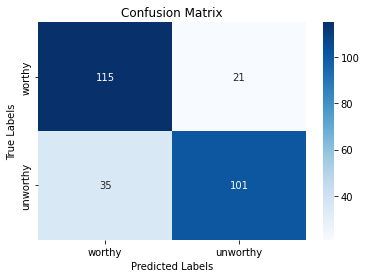

In [24]:
threshold = 0.5
y_pred = []
y_true = []
temp = []

model.eval()
with torch.no_grad():
    for test_ids, test_sentences, test_labels in loader_test:           
        test_labels = test_labels.float().to(device)
        output = model(test_sentences)

        temp.extend(output.tolist())
        output = (output > threshold).int()
        y_pred.extend(output.tolist())
        y_true.extend(test_labels.tolist())

print('Ranking:')
temp.sort(reverse=True)
print(temp[:10])

print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
# print(f'precision: {tp/(tp+fp)}')
# print(f'recall: {tp/(tp+fn)}')

print('Classification Report:')
print(classification_report(y_true, y_pred, digits=4)) # labels=[1,0], 

cm = confusion_matrix(y_true, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['worthy', 'unworthy'])
ax.yaxis.set_ticklabels(['worthy', 'unworthy'])

In [ ]:

# tp, tn, fp, fn = 0, 0, 0, 0
# for t in y_true:
#     truth = int(t)
#     for pred in y_pred:
#         if truth == 1 and pred == 1:
#             tp += 1
#         elif truth == 1 and pred == 0:
#             fn += 1
#         elif truth == 0 and pred == 1:
#             fp += 1
#         elif truth == 0 and pred == 0:
#             tn += 1